### 電影類型判斷

In [38]:
import json
from sklearn.feature_extraction import DictVectorizer
from collections import Counter
from nltk.tokenize import word_tokenize
from sklearn.decomposition import PCA
import numpy
from nltk.corpus import stopwords
stopword_list = stopwords.words('english')
from gensim.models import KeyedVectors
w2v = KeyedVectors.load_word2vec_format("wiki.en.5k.vec", binary=False)
import random
import pandas as pd

In [39]:
with open('data/lgbt-related_movielist_2004-2018_plotsummary.json') as f:
    data=json.load(f)
with open('data/lgbt-related_movielist_2004-2018_keywords.json') as f:
    data2=json.load(f)
with open('data/top270_plotsummary.json') as f:
    data3=json.load(f)
with open('data/top270_keywords.json') as f:
    data4=json.load(f)

training1=[]    
df_p=[]

for doc in list(data.keys()):
    if random.randint(0, 10) != 0:
        training1.append(doc)
        for m in data[doc]:
            df_p.extend(word_tokenize(m))
        for m in data2[doc]:
            df_p.extend(word_tokenize(m))
            
df_n=[]
training0=[]
for doc in list(data3.keys()):
    if random.randint(0, 10) != 0:
        training0.append(doc)
        for m in data3[doc]:
            df_n.extend(word_tokenize(m))
        for m in data4[doc]:
            df_n.extend(word_tokenize(m))

        
def count(data):
    term_dict = {}
    for term in data:
        if term not in term_dict:
            term_dict[term] = 1
        else:
            term_dict[term] = term_dict[term] +1
    return term_dict

word_p=count(df_p)
word_p=pd.DataFrame(list(word_p.items()), columns=['word', 'TF_p'])
word_n=count(df_n)
word_n=pd.DataFrame(list(word_n.items()), columns=['word', 'TF_n'])

In [40]:
word_p['len'] = word_p['word'].apply(lambda x: len(x))
word_n['len'] = word_n['word'].apply(lambda x: len(x))

word_p = word_p[word_p.len>2]
word_n = word_n[word_n.len>2]
word_all = pd.merge(word_p[['TF_p','word']], word_n[['TF_n','word']], how='inner')
word_all.head(5)

,TF_p,word,TF_n
0,1201022,and,861910
1,62505,best,19110
2,68061,friends,16415
3,463,total,1225
4,926,opposites,490


In [41]:
import numpy as np
word_all['positive'] = word_all.TF_p/sum(word_all.TF_p)
word_all['negative'] = word_all.TF_n/sum(word_all.TF_n)
word_all['log_ratio'] = np.log(word_all['positive']/word_all['negative'])
word_all['type'] = word_all['log_ratio'].apply(lambda x: 'Positive' if x>=0 else 'Negative')
word_all = word_all.sort_values(by='log_ratio', ascending=False)
most_p = word_all[:100]
most_n = word_all[-100:]

In [42]:
log_ratio_words=[]
for word in most_p.word.apply(str):
    log_ratio_words.append(word)
for word in most_n.word.apply(str):
    log_ratio_words.append(word)

In [44]:
most15_p=word_all[:15]
most15_n=word_all[-15:]

In [53]:
print(most15_p)

        TF_p           word  TF_n  positive  negative  log_ratio      type
45    943594            gay  9555  0.018548  0.000255   4.285280  Positive
2584   42133       closeted   490  0.000828  0.000013   4.146830  Positive
1059   18520    transgender   245  0.000364  0.000007   4.017997  Positive
3437   34725     homophobia   490  0.000683  0.000013   3.953459  Positive
871    46763  homosexuality   735  0.000919  0.000020   3.845626  Positive
1120   15279        hustler   245  0.000300  0.000007   3.825625  Positive
3089   13427          Olive   245  0.000264  0.000007   3.696413  Positive
2411  130566     homosexual  2450  0.002566  0.000065   3.668440  Positive
6438   12038            hiv   245  0.000237  0.000007   3.587214  Positive
101    41670       straight   980  0.000819  0.000026   3.442633  Positive
4490   17594    pornography   490  0.000346  0.000013   3.273557  Positive
1991    8797           Marc   245  0.000173  0.000007   3.273557  Positive
1555    8334        Russe

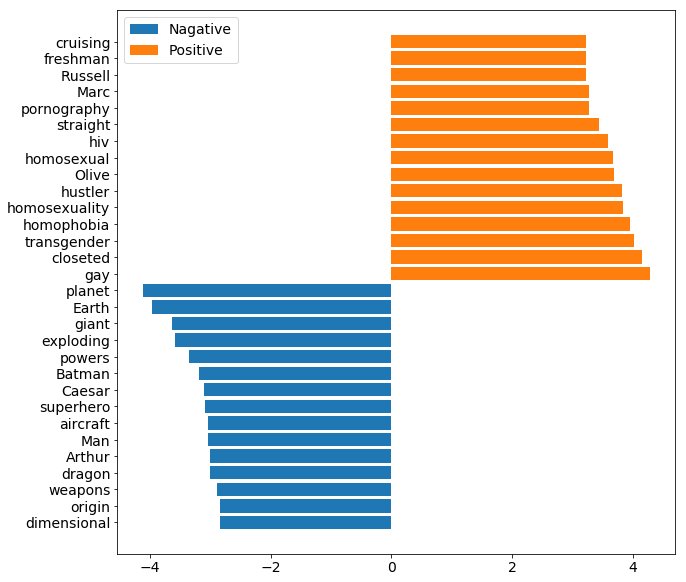

In [51]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10)) 
plt.rcParams.update({'font.size': 14})

plt.barh(most15_n['word'],most15_n['log_ratio'], label="Nagative")
plt.barh(most15_p['word'],most15_p['log_ratio'], label="Positive")
plt.legend()
plt.show()

#### train

In [30]:
def we_represent(tokens):
    vec = numpy.zeros(300)
    for tok in tokens:
        if tok.lower() in w2v and tok.lower() not in stopword_list and tok in log_ratio_words:
            vec += w2v[tok.lower()]
    return vec

training_instances = []
training_labels = []
test_instances = []
test_labels = []
x=[]

for doc in list(data.keys())[:100]:
    if doc not in training1:
        for m in data[doc]:
            x.extend(word_tokenize(m))
        for m in data2[doc]:
            x.extend(word_tokenize(m))
        test_instances.append(we_represent(x))
        x=[]
        test_labels.append(1)
    else:
        for m in data[doc]:
            x.extend(word_tokenize(m))
        for m in data2[doc]:
            x.extend(word_tokenize(m))
        training_instances.append(we_represent(x))
        x=[]
        training_labels.append(1)
        
for doc in list(data3.keys())[:100]:
    if doc not in training0:
        for m in data3[doc]:
            x.extend(word_tokenize(m))
        for m in data4[doc]:
            x.extend(word_tokenize(m))    
        test_instances.append(we_represent(x))
        x=[]
        test_labels.append(0)
    else:
        for m in data3[doc]:
            x.extend(word_tokenize(m))
        for m in data4[doc]:
            x.extend(word_tokenize(m))   
        training_instances.append(we_represent(x))
        x=[]
        training_labels.append(0)
        
print(len(training_labels))
print(len(test_labels))

182
18


In [31]:
def evaluate(actual_labels, predict_labels):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    for actual_label, predict_label in zip(actual_labels, predict_labels):
        if predict_label == 1 and actual_label == 1:
            tp += 1
        elif predict_label == 1 and actual_label == 0:
            fp += 1
        elif predict_label == 0 and actual_label == 1:
            fn += 1
        else:  #predict_label == 0 and actual_label == 0
            tn += 1
    print(tp,fp,fn,tn)
    accuracy = (tp + tn) / len(actual_labels)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    fscore = (2.0 * recall * precision) / (recall + precision)
    return accuracy, precision, recall, fscore

In [33]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(training_instances, training_labels)
predict_labels = model.predict(test_instances)

accuracy, precision, recall, fscore = evaluate(test_labels, predict_labels)
print("Accuracy: %f Precision: %f Recall: %f F-score: %f" % (accuracy, precision, recall, fscore))

11 0 0 7
Accuracy: 1.000000 Precision: 1.000000 Recall: 1.000000 F-score: 1.000000


In [ ]:
#from sklearn.svm import LinearSVC

#model = LinearSVC()
#model.fit(training_instances, training_labels)
#predict_labels = model.pre 

#### predict

In [34]:
with open('data/bestpicture_plotsummary.json') as f:
    data=json.load(f)
with open('data/bestpicture_keywords.json') as f:
    data2=json.load(f)
movielist=[]
x=[]
y=[]
result=[]
result_proba=[]
for movie in list(data.keys()):
    movielist.append(movie)
    for b in data[movie]:
        x.extend(word_tokenize(b))
    for b in data2[movie]:
        x.extend(word_tokenize(b))
    y.append(we_represent(x))
    x=[]

result=model.predict(y)
print(len(result))
result_counter=Counter()
for i in result:
    result_counter[i]+=1
print(result_counter)

111
Counter({0: 111})


In [35]:
result_proba=model.predict_proba(y)
print(result_proba)

[[0.95256161 0.04743839]
 [0.95256161 0.04743839]
 [0.95256161 0.04743839]
 [0.95256161 0.04743839]
 [0.95256161 0.04743839]
 [0.95256161 0.04743839]
 [0.95256161 0.04743839]
 [0.95256161 0.04743839]
 [0.95256161 0.04743839]
 [0.95256161 0.04743839]
 [0.95256161 0.04743839]
 [0.95256161 0.04743839]
 [0.95256161 0.04743839]
 [0.95256161 0.04743839]
 [0.95256161 0.04743839]
 [0.95256161 0.04743839]
 [0.95256161 0.04743839]
 [0.95256161 0.04743839]
 [0.95256161 0.04743839]
 [0.95256161 0.04743839]
 [0.95256161 0.04743839]
 [0.95256161 0.04743839]
 [0.95256161 0.04743839]
 [0.95256161 0.04743839]
 [0.95256161 0.04743839]
 [0.95256161 0.04743839]
 [0.95256161 0.04743839]
 [0.95256161 0.04743839]
 [0.95256161 0.04743839]
 [0.95256161 0.04743839]
 [0.95256161 0.04743839]
 [0.95256161 0.04743839]
 [0.95256161 0.04743839]
 [0.95256161 0.04743839]
 [0.95256161 0.04743839]
 [0.95256161 0.04743839]
 [0.95256161 0.04743839]
 [0.95256161 0.04743839]
 [0.95256161 0.04743839]
 [0.95256161 0.04743839]
